In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics
from sklearn.model_selection import KFold

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torch.optim as optim
import datasets, custom_transforms, GusarevModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False

# Input Directories
#data_BSE = "D:/data/JSRT/BSE_JSRT"
#data_normal = "D:/data/JSRT/JSRT"
data_BSE = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/suppressed/')
data_normal = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/normal/')
#data_val_normal = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/normal'
#data_val_BSE = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/suppressed/'

# Save directories:
output_save_directory = Path("./runs/6LayerCNN/177-20-20/10KFold")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate_{}.tar' )
PATH_SAVE_NETWORK_FINAL = os.path.join(output_save_directory, 'network_final_{}.pt')

# Image Size:
image_spatial_size = (256 , 256)
_batch_size = 5
split_k_folds=10
sample_keys_images = ["source", "boneless"]

# Optimisation
lr_ini = 0.001 
beta1 = 0.9
beta2 = 0.999

# Training
num_reals_per_epoch_paper = 4000 # in Gusarev et al. 2017
total_num_epochs_paper = 150
num_epochs_decay_lr_paper = 100
lr_decay_ratio = 0.25

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    if ngpu ==1:
        device=torch.device('cuda:0')

cuda
GeForce RTX 2080 Ti


In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
original_key = "source"
target_key = "boneless"
discriminator_keys_images = [original_key, target_key]
#ds_training = datasets.JSRT_CXR(data_normal, data_BSE,
#                         transform=tvtransforms.Compose([
                             # custom_transforms.HistogramEqualisation(discriminator_keys_images),-- check if training data is already equalised
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )
#ds_val = datasets.JSRT_CXR(data_val_normal, data_val_BSE,
#                         transform=tvtransforms.Compose([
                             #custom_transforms.HistogramEqualisation(discriminator_keys_images),#
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )

In [3]:
# Loss definitions

# Gusarev Loss
def criterion_MSELoss(testImage, referenceImage):
    mse = nn.MSELoss()
    mse_loss = mse(testImage, referenceImage)
    return mse_loss, mse_loss, torch.zeros(1)
def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mse = nn.MSELoss() # L2 used for easier optimisation c.f. L1
    mse_loss = mse(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mse_loss + alpha*msssim_loss
    return total_loss, mse_loss, msssim_loss

boneless
Fold 1
Using 6-Layer MultiCNN Model.
Epoch Factor: 23
Adjusting learning rate of group 0 to 1.0000e-03.
FLAG: NO CHECKPOINT LOADED.
0.001
[0/3450][0/36]	Total Loss: 0.8649	MSELoss: 0.1558	MSSSIM Loss: 1.0000
[0/3450][1/36]	Total Loss: 0.2829	MSELoss: 0.0652	MSSSIM Loss: 0.3244
[0/3450][2/36]	Total Loss: 0.4568	MSELoss: 0.1124	MSSSIM Loss: 0.5224
[0/3450][3/36]	Total Loss: 0.2384	MSELoss: 0.0381	MSSSIM Loss: 0.2765
[0/3450][4/36]	Total Loss: 0.3292	MSELoss: 0.0455	MSSSIM Loss: 0.3833
[0/3450][5/36]	Total Loss: 0.2321	MSELoss: 0.0353	MSSSIM Loss: 0.2696
[0/3450][6/36]	Total Loss: 0.1805	MSELoss: 0.0225	MSSSIM Loss: 0.2106
[0/3450][7/36]	Total Loss: 0.2666	MSELoss: 0.0927	MSSSIM Loss: 0.2997
[0/3450][8/36]	Total Loss: 0.1932	MSELoss: 0.0505	MSSSIM Loss: 0.2204
[0/3450][9/36]	Total Loss: 0.0788	MSELoss: 0.0073	MSSSIM Loss: 0.0924
[0/3450][10/36]	Total Loss: 0.0496	MSELoss: 0.0065	MSSSIM Loss: 0.0578
[0/3450][11/36]	Total Loss: 0.0481	MSELoss: 0.0072	MSSSIM Loss: 0.0559
[0/3450][12

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
Saved Intermediate: runs\6LayerCNN\177-20-20\10KFold\network_intermediate_0.tar
Fold 2
Using 6-Layer MultiCNN Model.
Epoch Factor: 23
Adjusting learning rate of group 0 to 1.0000e-03.
FLAG: NO CHECKPOINT LOADED.
0.001
[0/3450][0/36]	Total Loss: 0.6031	MSELoss: 0.1059	MSSSIM Loss: 0.6979
[0/3450][1/36]	Total Loss: 0.3897	MSELoss: 0.1232	MSSSIM Loss: 0.4405
[0/3450][2/36]	Total Loss: 0.4058	MSELoss: 0.0594	MSSSIM Loss: 0.4717
[0/3450][3/36]	Total Loss: 0.3589	MSELoss: 0.0645	MSSSIM Loss: 0.4150
[0/3450][4/36]	Total Loss: 0.3474	MSELoss: 0.0438	MSSSIM Loss: 0.4052
[0/3450][5/36]	Total Loss: 0.2525	

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
Saved Intermediate: runs\6LayerCNN\177-20-20\10KFold\network_intermediate_1.tar


Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

[3000/3450][30/36]	Total Loss: 0.0089	MSELoss: 0.0005	MSSSIM Loss: 0.0105
[3000/3450][31/36]	Total Loss: 0.0083	MSELoss: 0.0003	MSSSIM Loss: 0.0099
[3000/3450][32/36]	Total Loss: 0.0106	MSELoss: 0.0006	MSSSIM Loss: 0.0125
[3000/3450][33/36]	Total Loss: 0.0076	MSELoss: 0.0003	MSSSIM Loss: 0.0090
[3000/3450][34/36]	Total Loss: 0.0169	MSELoss: 0.0024	MSSSIM Loss: 0.0196
[3000/3450][35/36]	Total Loss: 0.0091	MSELoss: 0.0010	MSSSIM Loss: 0.0106
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

[3000/3450][23/36]	Total Loss: 0.0110	MSELoss: 0.0012	MSSSIM Loss: 0.0129
[3000/3450][24/36]	Total Loss: 0.0073	MSELoss: 0.0003	MSSSIM Loss: 0.0086
[3000/3450][25/36]	Total Loss: 0.0077	MSELoss: 0.0005	MSSSIM Loss: 0.0091
[3000/3450][26/36]	Total Loss: 0.0119	MSELoss: 0.0008	MSSSIM Loss: 0.0140
[3000/3450][27/36]	Total Loss: 0.0064	MSELoss: 0.0003	MSSSIM Loss: 0.0076
[3000/3450][28/36]	Total Loss: 0.0095	MSELoss: 0.0005	MSSSIM Loss: 0.0112
[3000/3450][29/36]	Total Loss: 0.0093	MSELoss: 0.0005	MSSSIM Loss: 0.0110
[3000/3450][30/36]	Total Loss: 0.0089	MSELoss: 0.0004	MSSSIM Loss: 0.0106
[3000/3450][31/36]	Total Loss: 0.0092	MSELoss: 0.0004	MSSSIM Loss: 0.0109
[3000/3450][32/36]	Total Loss: 0.0118	MSELoss: 0.0010	MSSSIM Loss: 0.0139
[3000/3450][33/36]	Total Loss: 0.0086	MSELoss: 0.0003	MSSSIM Loss: 0.0101
[3000/3450][34/36]	Total Loss: 0.0061	MSELoss: 0.0002	MSSSIM Loss: 0.0072
[3000/3450][35/36]	Total Loss: 0.0118	MSELoss: 0.0009	MSSSIM Loss: 0.0139
Adjusting learning rate of group 0 to 

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

[3000/3450][16/36]	Total Loss: 0.0100	MSELoss: 0.0006	MSSSIM Loss: 0.0118
[3000/3450][17/36]	Total Loss: 0.0100	MSELoss: 0.0009	MSSSIM Loss: 0.0118
[3000/3450][18/36]	Total Loss: 0.0100	MSELoss: 0.0006	MSSSIM Loss: 0.0118
[3000/3450][19/36]	Total Loss: 0.0098	MSELoss: 0.0009	MSSSIM Loss: 0.0115
[3000/3450][20/36]	Total Loss: 0.0079	MSELoss: 0.0004	MSSSIM Loss: 0.0093
[3000/3450][21/36]	Total Loss: 0.0084	MSELoss: 0.0005	MSSSIM Loss: 0.0100
[3000/3450][22/36]	Total Loss: 0.0097	MSELoss: 0.0005	MSSSIM Loss: 0.0115
[3000/3450][23/36]	Total Loss: 0.0085	MSELoss: 0.0004	MSSSIM Loss: 0.0101
[3000/3450][24/36]	Total Loss: 0.0098	MSELoss: 0.0006	MSSSIM Loss: 0.0116
[3000/3450][25/36]	Total Loss: 0.0102	MSELoss: 0.0007	MSSSIM Loss: 0.0121
[3000/3450][26/36]	Total Loss: 0.0073	MSELoss: 0.0003	MSSSIM Loss: 0.0086
[3000/3450][27/36]	Total Loss: 0.0090	MSELoss: 0.0008	MSSSIM Loss: 0.0106
[3000/3450][28/36]	Total Loss: 0.0091	MSELoss: 0.0004	MSSSIM Loss: 0.0108
[3000/3450][29/36]	Total Loss: 0.0137	

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

[3000/3450][9/36]	Total Loss: 0.0093	MSELoss: 0.0009	MSSSIM Loss: 0.0110
[3000/3450][10/36]	Total Loss: 0.0094	MSELoss: 0.0005	MSSSIM Loss: 0.0111
[3000/3450][11/36]	Total Loss: 0.0106	MSELoss: 0.0011	MSSSIM Loss: 0.0124
[3000/3450][12/36]	Total Loss: 0.0120	MSELoss: 0.0006	MSSSIM Loss: 0.0142
[3000/3450][13/36]	Total Loss: 0.0081	MSELoss: 0.0004	MSSSIM Loss: 0.0096
[3000/3450][14/36]	Total Loss: 0.0102	MSELoss: 0.0006	MSSSIM Loss: 0.0120
[3000/3450][15/36]	Total Loss: 0.0091	MSELoss: 0.0004	MSSSIM Loss: 0.0108
[3000/3450][16/36]	Total Loss: 0.0091	MSELoss: 0.0006	MSSSIM Loss: 0.0107
[3000/3450][17/36]	Total Loss: 0.0109	MSELoss: 0.0007	MSSSIM Loss: 0.0129
[3000/3450][18/36]	Total Loss: 0.0076	MSELoss: 0.0003	MSSSIM Loss: 0.0090
[3000/3450][19/36]	Total Loss: 0.0084	MSELoss: 0.0004	MSSSIM Loss: 0.0100
[3000/3450][20/36]	Total Loss: 0.0125	MSELoss: 0.0011	MSSSIM Loss: 0.0146
[3000/3450][21/36]	Total Loss: 0.0080	MSELoss: 0.0004	MSSSIM Loss: 0.0094
[3000/3450][22/36]	Total Loss: 0.0105	M

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

[2000/3300][35/36]	Total Loss: 0.0075	MSELoss: 0.0003	MSSSIM Loss: 0.0089
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of gro

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
[3000/3300][0/36]	Total Loss: 0.0133	MSELoss: 0.0008	MSSSIM Loss: 0.0157
[3000/3300][1/36]	Total Loss: 0.0072	MSELoss: 0.0005	MSSSIM Loss: 0.0085
[3000/3300][2/36]	Total Loss: 0.0088	MSELoss: 0.0005	MSSSIM Loss: 0.0104
[3000/3300][3/36]	Total Loss: 0.0097	MSELoss: 0.0005	MSSSIM Loss: 0.0114
[3000/3300][4/36]	Total Loss: 0.0091	MSELoss: 0.0007	MSSSIM Loss: 0.0106
[3000/3300][5/36]	Total Loss: 0.0097	MSELoss: 0.0005	MSSSIM Loss: 0.0114
[3000/3300][6/36]	Total Loss: 0.0061	MSELoss: 0.0003	MSSSIM Loss: 0.0071
[3000/3300][7/36]	Total Loss: 0.0066	MSELoss: 0.0005	MSSSIM Loss: 0.0077
[3000/3300][8/36]	Total Loss: 0.0143	MSELoss: 0.0010	MSSSIM Loss: 0.0169
[3000/3300][9/36]	Total Loss: 0.0077	MSELoss: 0.0004	MSSSIM Loss: 0.0091
[3000/3300][10/36]	Total Loss: 0.0063	MSELoss: 0.0002	MSSSIM Loss: 0.0075
[3000/3300][11/36]	Total Loss: 0.0091	MSELoss: 0.0006	MSSSIM Loss: 0.0107
[3000/3300][12/36]	Total Loss: 0.0093	MSELoss: 0.0006	MSSSIM Los

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

[2000/3300][32/36]	Total Loss: 0.0093	MSELoss: 0.0006	MSSSIM Loss: 0.0109
[2000/3300][33/36]	Total Loss: 0.0100	MSELoss: 0.0005	MSSSIM Loss: 0.0118
[2000/3300][34/36]	Total Loss: 0.0107	MSELoss: 0.0009	MSSSIM Loss: 0.0125
[2000/3300][35/36]	Total Loss: 0.0100	MSELoss: 0.0005	MSSSIM Loss: 0.0118
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
[3000/3300][0/36]	Total Loss: 0.0096	MSELoss: 0.0006	MSSSIM Loss: 0.0113
[3000/3300][1/36]	Total Loss: 0.0103	MSELoss: 0.0009	MSSSIM Loss: 0.0121
[3000/3300][2/36]	Total Loss: 0.0099	MSELoss: 0.0010	MSSSIM Loss: 0.0116
[3000/3300][3/36]	Total Loss: 0.0074	MSELoss: 0.0010	MSSSIM Loss: 0.0086
[3000/3300][4/36]	Total Loss: 0.0089	MSELoss: 0.0005	MSSSIM Loss: 0.0105
[3000/3300][5/36]	Total Loss: 0.0083	MSELoss: 0.0007	MSSSIM Loss: 0.0098
[3000/3300][6/36]	Total Loss: 0.0086	MSELoss: 0.0004	MSSSIM Loss: 0.0101
[3000/3300][7/36]	Total Loss: 0.0098	MSELoss: 0.0006	MSSSIM Loss: 0.0115
[3000/3300][8/36]	Total Loss: 0.0097	MSELoss: 0.0005	MSSSIM Loss: 0.0114
[3000/3300][9/36]	Total Loss: 0.0079	MSELoss: 0.0006	MSSSIM Loss: 0.0093
[3000/3300][10/36]	Total Loss: 0.0106	

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

[2000/3300][30/36]	Total Loss: 0.0069	MSELoss: 0.0003	MSSSIM Loss: 0.0081
[2000/3300][31/36]	Total Loss: 0.0139	MSELoss: 0.0009	MSSSIM Loss: 0.0164
[2000/3300][32/36]	Total Loss: 0.0081	MSELoss: 0.0005	MSSSIM Loss: 0.0095
[2000/3300][33/36]	Total Loss: 0.0085	MSELoss: 0.0007	MSSSIM Loss: 0.0100
[2000/3300][34/36]	Total Loss: 0.0112	MSELoss: 0.0011	MSSSIM Loss: 0.0132
[2000/3300][35/36]	Total Loss: 0.0078	MSELoss: 0.0004	MSSSIM Loss: 0.0092
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.

Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Adjusting learning rate of group 0 to 1.0000e-03

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
[3000/3300][0/36]	Total Loss: 0.0089	MSELoss: 0.0006	MSSSIM Loss: 0.0104
[3000/3300][1/36]	Total Loss: 0.0099	MSELoss: 0.0005	MSSSIM Loss: 0.0117
[3000/3300][2/36]	Total Loss: 0.0088	MSELoss: 0.0004	MSSSIM Loss: 0.0104
[3000/3300][3/36]	Total Loss: 0.0098	MSELoss: 0.0005	MSSSIM Loss: 0.0116
[3000/3300][4/36]	Total Loss: 0.0078	MSELoss: 0.0005	MSSSIM Loss: 0.0092
[3000/3300][5/36]	Total Loss: 0.0083	MSELoss: 0.0006	MSSSIM Loss: 0.0097
[3000/3300][6/36]	Total Loss: 0.0108	MSELoss: 0.0008	MSSSIM Loss: 0.0127
[3000/3300][7/36]	Total Loss: 0.0110	MSELoss: 0.0006	MSSSIM Loss: 0.0129
[3000/3300

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting learning rate of group 0 to 7.5000e-04.
0.00075
Adjusting lear

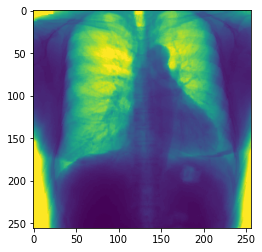

In [4]:
# Training

# Data augmentation transformations
data_transforms = {
    'train_transforms': tvtransforms.Compose([
    custom_transforms.RandomAutocontrast(sample_keys_images, cutoff_limits=(0.1,0.1)),
    custom_transforms.CenterCrop(sample_keys_images,256),
    custom_transforms.RandomHorizontalFlip(sample_keys_images, 0.5),
    custom_transforms.RandomAffine(sample_keys_images, degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
    custom_transforms.ToTensor(sample_keys_images),
    custom_transforms.ImageComplement(sample_keys_images),
    ])
      ,
    'test_transforms': tvtransforms.Compose([
      custom_transforms.ToTensor(sample_keys_images),
    ]),
    }

# K-FOLD VALIDATION
#dataset = ConcatDataset([ds_training, ds_val])
splits=KFold(n_splits=split_k_folds,shuffle=True,random_state=42)
foldperf={}

print(target_key)
dataset = datasets.JSRT_CXR(data_normal, data_BSE, transform=None)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    history = {'loss':[], 'ssim_acc':[]}
    
    # Subset sample from dataset
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    dl_training = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=train_sampler, num_workers=0)
    dl_validation = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=test_sampler, num_workers=0)
    
    # Print example of transformed image
    for count, sample in enumerate(dl_training):
        image = sample["source"][0,:]
        image = torch.squeeze(image)
        plt.imshow(image)
        if count == 0:
            break
    
    # Network
    input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
    net = GusarevModel.MultilayerCNN(input_array_size)
    # Initialise weights
    net.apply(weights_init)

    # Multi-GPU
    if (device.type == 'cuda') and (ngpu > 1):
        print("Neural Net on GPU")
        net = nn.DataParallel(net, list(range(ngpu)))
    net = net.to(device)

    # Optimiser
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

    # Learning Rate Scheduler
    epoch_factor = round(num_reals_per_epoch_paper/len(train_idx)) # need to have this factor as many epochs as that described in the paper
    print("Epoch Factor: "+str(epoch_factor))
    total_num_epochs = int(total_num_epochs_paper*epoch_factor)
    num_epochs_decay_lr = int(num_epochs_decay_lr_paper*epoch_factor)
    lambda_rule = lambda epoch: 1*((1-lr_decay_ratio)**(epoch//num_epochs_decay_lr))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule, verbose=True)
    
    # For each epoch
    epochs_list = []
    img_list = []
    training_loss_list = []
    reals_shown = []
    #validation_loss_per_epoch_list = []
    #training_loss_per_epoch_list = []
    loss_per_epoch={"training":[], "validation":[]}
    ssim_average={"training":[], "validation":[]}

    
    
    #fixed_val_sample = next(iter(dl_validation))
    #fig, ax = plt.subplots(1,2)
    #ax[0].imshow(fixed_val_sample[original_key][0,0,:])
    #ax[1].imshow(fixed_val_sample[target_key][0,0,:])
    #plt.show()
    
    # optionally resume from a checkpoint
    if flag_load_previous_save:
        if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
            print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
            checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
            start_epoch = checkpoint['epoch_next']
            reals_shown_now = checkpoint['reals_shown']
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            net.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                                start_epoch, reals_shown_now))
            print(scheduler)
        else:
            print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
            raise RuntimeError("No checkpoint found at specified path.")
    else:
        print("FLAG: NO CHECKPOINT LOADED.")
        reals_shown_now = 0
        start_epoch=0

    # Loop variables
    flag_break = False # when debugging, this will automatically go to True
    iters = 0
    net.train()
    for param in net.parameters():
        param.requires_grad = True
    for epoch in range(start_epoch, total_num_epochs):
        print(optimizer.param_groups[0]['lr'])
        sum_loss_in_epoch = 0
        for i, data in enumerate(dl_training):
            # Training
            net.zero_grad()
            noisy_data = data[original_key].to(device)
            cleaned_data = net(noisy_data)
            loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_data, data[target_key].to(device))
            loss.backward() # calculate gradients
            optimizer.step() # optimiser step along gradients

            # Output training stats
            if epoch%1000 == 0:
                print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMSELoss: %.4f\tMSSSIM Loss: %.4f'
                      % (epoch, total_num_epochs, i, len(dl_training),
                         loss.item(), maeloss.item(), msssim_loss.item()))
            # Record generator output
            #if reals_shown_now%(100*_batch_size)==0:
            #    with torch.no_grad():
            #        val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            #    print("Printing to img_list")
            #    img_list.append(vutils.make_grid(val_cleaned[0:1,0:1,:], padding=2, normalize=True))
            #iters +=1
            #if flag_debug and iters>=10:
            #    flag_break = True
            #    break

            # Running counter of reals shown
            reals_shown_now += _batch_size
            reals_shown.append(reals_shown_now)

            # Training loss list for loss per minibatch
            training_loss_list.append(loss.item()) # training loss
            sum_loss_in_epoch += loss.item()*len(cleaned_data)
        # Turn the sum loss in epoch into a loss-per-epoch
        loss_per_epoch["training"].append(sum_loss_in_epoch/len(train_idx))


        with torch.no_grad():
            # Training Accuracy per EPOCH
            ssim_training_list = []
            for train_count, data in enumerate(dl_training):
                noisy_training_data = data[original_key].to(device)
                true_training_data = data[target_key]
                cleaned_training_data = net(noisy_training_data)

                for ii, image in enumerate(cleaned_training_data):
                    clean_training_numpy = image.cpu().detach().numpy()
                    true_training_numpy = true_training_data[ii].numpy()
                    clean_training_numpy = np.moveaxis(clean_training_numpy, 0, -1)
                    true_training_numpy = np.moveaxis(true_training_numpy, 0, -1)
                    ssim_training = skimage.metrics.structural_similarity(clean_training_numpy, true_training_numpy, multichannel=True)
                    ssim_training_list.append(ssim_training) # SSIM per image
            ssim_average["training"].append(np.mean(ssim_training_list))

            # Validation Loss and Accuracy per EPOCH
            sum_loss_in_epoch =0
            ssim_val_list = []
            for val_count, sample in enumerate(dl_validation):
                noisy_val_data = sample[original_key].to(device)
                cleaned_val_data = net(noisy_val_data)

                # Loss
                true_val_data = sample[target_key]
                val_loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_val_data, true_val_data.to(device))
                sum_loss_in_epoch += val_loss.item()*len(cleaned_val_data)

                # Accuracy
                for ii, image in enumerate(cleaned_val_data):
                    clean_val_numpy = image.cpu().detach().numpy()
                    true_val_numpy = true_val_data[ii].numpy()
                    clean_val_numpy = np.moveaxis(clean_val_numpy, 0, -1)
                    true_val_numpy = np.moveaxis(true_val_numpy, 0, -1)
                    ssim_val = skimage.metrics.structural_similarity(clean_val_numpy, true_val_numpy, multichannel=True)
                    ssim_val_list.append(ssim_val) # SSIM per image
            # After considering all validation images
            loss_per_epoch["validation"].append(sum_loss_in_epoch/len(val_idx))
            ssim_average["validation"].append(np.mean(ssim_val_list))
        epochs_list.append(epoch)
        # LR Scheduler after epoch
        scheduler.step()
        
        #if epoch % 5 == 0:
        #    if not flag_debug:
        #        #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
        #        torch.save({
        #        'epochs_completed': epoch+1,
        #        'epoch_next': epoch+1,
        #        'model_state_dict': net.state_dict(),
        #        'optimizer_state_dict': optimizer.state_dict(),
        #        'loss': loss,
        #        'scheduler_state_dict': scheduler.state_dict(),
        #        'reals_shown': reals_shown_now
        #        }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        #        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        #if flag_break:
        #    break
        
    #After all epochs, save results:
    history["loss"] = loss_per_epoch
    history["ssim_acc"] = ssim_average
    
    foldperf['fold{}'.format(fold+1)] = history
    
    # Final Save for each fold
    if not flag_debug:
        torch.save({
                'epochs_completed': epoch+1,
                'epoch_factor': epoch_factor,
                'total_num_epochs': total_num_epochs,
                'total_num_epochs_paper': total_num_epochs_paper,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'scheduler_state_dict': scheduler.state_dict(),
                'reals_shown': reals_shown_now
                }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold)))
    

In [5]:
if not flag_debug:
        torch.save({
                'epochs_completed': epoch+1,
                'epoch_factor': epoch_factor,
                'total_num_epochs': total_num_epochs,
                'total_num_epochs_paper': total_num_epochs_paper,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'scheduler_state_dict': scheduler.state_dict(),
                'reals_shown': reals_shown_now
                }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold))
        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold)))

Saved Intermediate: runs\6LayerCNN\177-20-20\10KFold\network_intermediate_9.tar


Training complete
Performance of 10 fold cross validation
Average Training Loss: 0.011 	 Average Test Loss: 0.012 	 Average Training Acc: 0.98 	 Average Test Acc: 0.98
Best fold: 4


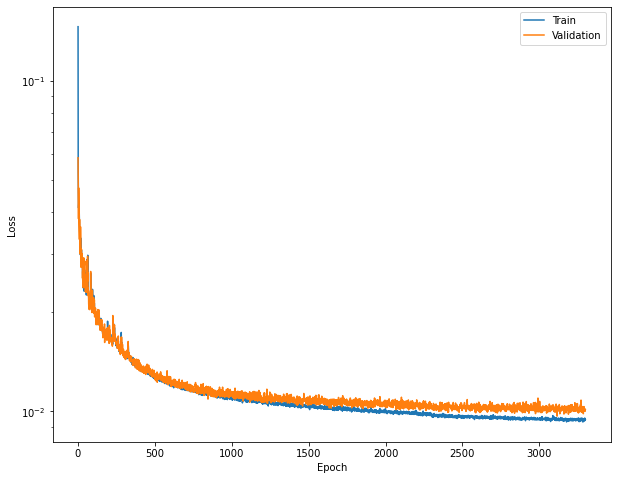

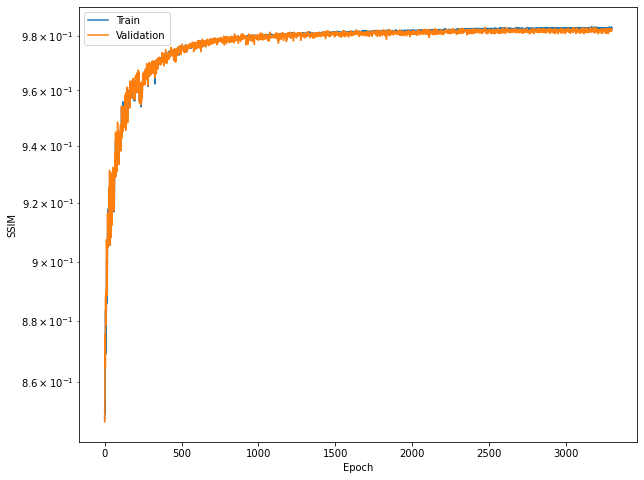

In [10]:
print("Training complete")
# Find the best fold


# AVERAGE PERFORMANCE
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['training']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['validation']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['training']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['validation']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}"
      .format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))
print("Best fold: {}".format(np.argmax(testa_f)))

# Averaging accuracy and loss
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}
for i in range(total_num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['training'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['validation'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['ssim_acc']['training'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['ssim_acc']['validation'][i] for f in range(k)]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
plt.show()

In [ ]:
%matplotlib inline 
import math
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Accuracy
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(epochs_list, ssim_average["training"], label='training')
plt.plot(epochs_list, ssim_average["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
    
# All losses
plt.figure(figsize=(10,5))
plt.title("Losses")
plt.plot(epochs_list, loss_per_epoch["training"], label='training')
plt.plot(epochs_list, loss_per_epoch["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss during training")
plt.plot(reals_shown, [math.log10(y) for y in training_loss_list])
plt.xlabel("reals_shown")
plt.ylabel("Training Log10(Loss)")
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_training_loss"+".png"))


    
# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
#print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
#if not flag_debug:
#    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
#fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111)
#plt.axis("off")
#ims = []
#training_ims_shown = []
#for i, im in enumerate(img_list):
#    if i % 50 == 0:  # controls how many images are printed into the animation
#        training_ims_shown = i*(100*_batch_size)
#        frame = ax.imshow(np.transpose(im,(1,2,0)))
#        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
#        ims.append([frame, t])
#ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
#if not flag_debug:
#    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)